# Analysis B: Gaze Distribution

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from scipy import stats

import pickle

def save_obj(obj, name, path = 'obj/'):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name, path = 'obj/'):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)


gazedf = pd.read_csv('obj/gaze_df.csv', index_col =0) #load gaze distribution
participants = load_obj('participants')


# Gazedistributions
gazedf contains all the gaze distribution for all the participants for all trials in all experimental conditions (time frame starting from ttp<9s to ttp = 0s.

Surface meanings:
* gaze_fw = front window
* gaze_ic = instrument cluster
* gaze_lm = left mirror
* gaze_lmopt = left mirror optimistic surface (meaning the larger drawn square)
* gaze_tm = gaze top mirror
* gaze_tmopt = top mirror optimist
* none = not on any surface

The figure below shows how the surfaces were defined in the software.

<img src="img/areas.png" alt="Drawing" style="width: 900px;"/>

A single gaze distribution for a trial looks as follows.

In [3]:
#select a participant, and run and show dataframe
p = participants[0]
r = 'uctun' #run, (experimental condition)
direction = 'FR' # alternatives: FRs, FL, BL, BR


selected = gazedf[(gazedf['participant']==p) &(gazedf['run'] == r) &(gazedf['direction']=='FR')]
selected

,nr,participant,run,direction,surface,count
0,29,XSMS,uctun,FR,total,1516
0,29,XSMS,uctun,FR,gaze_fw,1381
0,29,XSMS,uctun,FR,gaze_ic,17
0,29,XSMS,uctun,FR,gaze_lm,36
0,29,XSMS,uctun,FR,gaze_lmopt,83
0,29,XSMS,uctun,FR,gaze_tm,0
0,29,XSMS,uctun,FR,gaze_tmopt,0
0,29,XSMS,uctun,FR,none,36
0,40,XSMS,uctun,FR,total,1935
0,40,XSMS,uctun,FR,gaze_fw,1659


In [4]:
gazedf[(gazedf['nr']==20)]

,nr,participant,run,direction,surface,count
0,20,XSMS,nouctun,FL,total,1029
0,20,XSMS,nouctun,FL,gaze_fw,897
0,20,XSMS,nouctun,FL,gaze_ic,122
0,20,XSMS,nouctun,FL,gaze_lm,0
0,20,XSMS,nouctun,FL,gaze_lmopt,0
0,20,XSMS,nouctun,FL,gaze_tm,0
0,20,XSMS,nouctun,FL,gaze_tmopt,0
0,20,XSMS,nouctun,FL,none,10
0,20,SPPV,noucrain,F,total,1205
0,20,SPPV,noucrain,F,gaze_fw,924


Code by Matti starts here

## Figures

DVs: 
- ratio of gaze duration on front vs rearview mirrors. Answers the question: What percentage of gaze on the road was on the front?

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# load gaze data with duration information
gaze2df = pd.read_csv('obj/gazedfWithDurations.csv', index_col =0)
#participants = load_obj('participants')

In [7]:
# check structure of data on one trial for reference
gaze2df[(gaze2df['nr']==20)]

,nr,participant,run,direction,surface,count,dur
0,20,XSMS,nouctun,FL,total,1029,8619.97
0,20,XSMS,nouctun,FL,gaze_fw,897,8619.97
0,20,XSMS,nouctun,FL,gaze_ic,122,8619.97
0,20,XSMS,nouctun,FL,gaze_lm,0,8619.97
0,20,XSMS,nouctun,FL,gaze_lmopt,0,8619.97
0,20,XSMS,nouctun,FL,gaze_tm,0,8619.97
0,20,XSMS,nouctun,FL,gaze_tmopt,0,8619.97
0,20,XSMS,nouctun,FL,none,10,8619.97
0,20,SPPV,noucrain,F,total,1205,10150.00
0,20,SPPV,noucrain,F,gaze_fw,924,10150.00


In [8]:
# translations and cosmetics
COLORS = {}
# blocks
LABELS = {}
LABELS['noucfog'] = 'MC-HU'
LABELS['noucrain'] = 'MU-HC'
LABELS['nouctun'] = 'MU-HU'
LABELS['ucrain'] = 'MU-HC-uc'
LABELS['uctun'] = 'MU-HU-uc'


COLORS[LABELS['noucfog'] ] =  'coral'
COLORS[LABELS['noucrain'] ] = 'lightblue'
COLORS[LABELS['nouctun']] =  'lightblue'
COLORS[LABELS['ucrain']] = 'deepskyblue'
COLORS[LABELS['uctun']] = 'deepskyblue'

COLORS['B'] = COLORS['Back'] = 'tomato'
COLORS['F'] = COLORS['Front'] = 'gold'

# Note to Tom: label convention changed slightly. 
# Added C for Communication to cases in which uncertainty is communicated 
# This way there is no ambiguity

LABELS['B'] = 'Back'
LABELS['F'] = 'Front'

In [9]:
def gaze_ratio(df, 
               frontsurfaces=['gaze_fw'],
               backsurfaces=['gaze_lmopt', 
                             'gaze_tmopt'], 
               rationames=['ratiofront', 
                           'ratioback']):
    """Create new dataframe that provides for each trial the 
    percentage of gaze points in one set of areas of of interest compared
    to the sum of gaze points for the primary set of AOIs and another
    set of AOIs. 
    
    With the default parameters the ratio of front/(front + rearview)
    is calculated. 
    
    Returns: 
        New dataframe with columns as specified by 'rationames'
    """
    
    # define column labels
    columns=['participant', 'nr', 'run', 'direction', 'Approach'] + rationames
    ratiodf = pd.DataFrame(columns=columns)
    
    # for each participant
    participants = df.participant.unique()
    for participant in participants:
        # for each trial
        trials = df.query('participant == "{}"'.format(participant)).nr.unique()
        for trial in trials:
            
            condition = 'participant == "{}" and nr == {}'.format(participant, trial)
            runs = df.query(condition).run.unique()
            
            # because some "nr"s are assigned more than once, 
            # "run" is needed for further separation 
            for run in runs:
                condition = 'participant == "{}" and nr == {} and run == "{}"'.format(participant, trial, run)
                front = 0.0
                for surface in frontsurfaces:
                    surfcond = '{} and surface == "{}"'.format(condition, surface)
                    front += df.query(surfcond)['count'][0]
                back = 0.0
                for surface in backsurfaces:
                    surfcond = '{} and surface == "{}"'.format(condition, surface)
                    back += df.query(surfcond)['count'][0]
                #print('participant: {} trial: {}, front {}'.format(participant, trial, front))#/(front+back))
                ratiodf = ratiodf.append({
                    'participant':participant,
                    'nr':trial,
                    'run':LABELS[run], 
                    'direction':df.query(condition).direction.unique()[0],
                    'Approach':LABELS[df.query(condition).direction.unique()[0][0]],
                    rationames[0]:front/(front+back),
                    rationames[1]:back/(front+back)
                }, ignore_index=True)
            
    ratiodf['run'] = ratiodf.run.astype('category')
    ratiodf['direction'] = ratiodf.direction.astype('category')
    return ratiodf

In [10]:
# get ratio of front/(front + mirror)
ratiodf_f_b = gaze_ratio(gaze2df)

# remove nan entries
ratiodf_f_b = ratiodf_f_b.dropna()
#ratiodf

/Users/tom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/Users/tom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
ratiodf_f_b

,participant,nr,run,direction,Approach,ratiofront,ratioback
0,TWOU,180,MU-HU,FL,Front,1.000000,0.000000
1,TWOU,181,MU-HU,FR,Front,1.000000,0.000000
2,TWOU,182,MU-HU,FL,Front,1.000000,0.000000
3,TWOU,183,MU-HU,BL,Back,0.953704,0.046296
4,TWOU,184,MU-HU,BR,Back,1.000000,0.000000
5,TWOU,185,MU-HU,FRs,Front,1.000000,0.000000
6,TWOU,186,MU-HU,FL,Front,1.000000,0.000000
7,TWOU,187,MU-HU,BL,Back,1.000000,0.000000
8,TWOU,188,MU-HU,FRs,Front,1.000000,0.000000
9,TWOU,189,MU-HU,BR,Back,1.000000,0.000000


#### Figures of front/(front+back) ratios for different subsets of the data

<IPython.core.display.Javascript object>


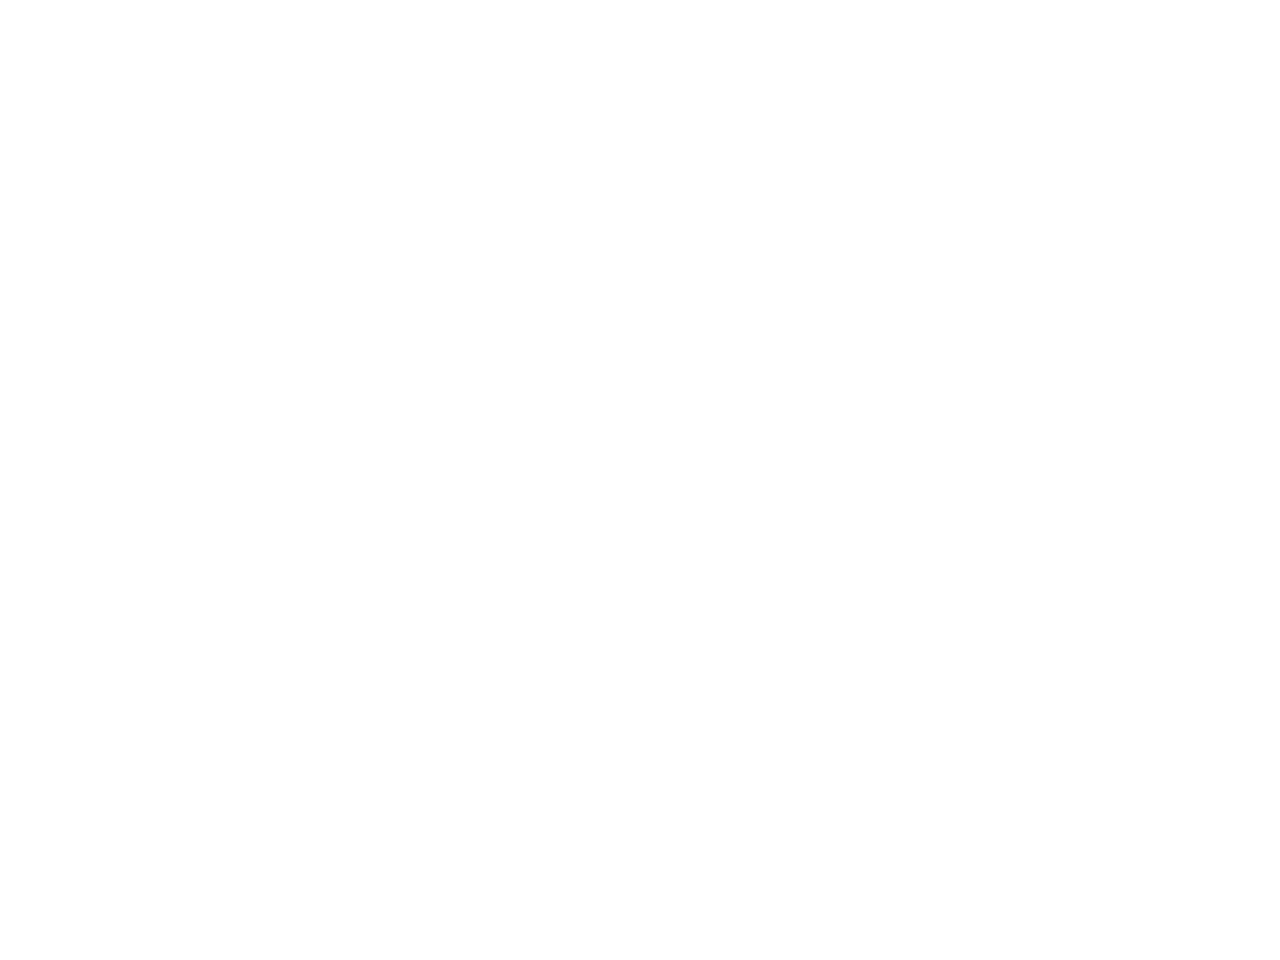

In [12]:
# 1. Boxplot showing ratios for each condition, discriminating between 
#    trials with the approach from the front (F) and the back (B)

sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots()
allratios = sns.boxplot(x="ratiofront", y="run", hue="Approach", #notch=True, 
                        palette=COLORS, data=ratiodf_f_b, ax=ax)
allratios.set_xlim(0,1)
allratios.set_ylabel('Condition')
allratios.set_xlabel('Ratio of gaze on front road')
allratios.set_title('All conditions')
plt.tight_layout() # needed to show y-label

plt.show()

In [13]:
ratiodf_f_b.query('Approach == "Back"')

,participant,nr,run,direction,Approach,ratiofront,ratioback
3,TWOU,183,MU-HU,BL,Back,0.953704,0.046296
4,TWOU,184,MU-HU,BR,Back,1.000000,0.000000
7,TWOU,187,MU-HU,BL,Back,1.000000,0.000000
9,TWOU,189,MU-HU,BR,Back,1.000000,0.000000
10,TWOU,190,MU-HU,BL,Back,1.000000,0.000000
11,TWOU,191,MU-HU,BR,Back,0.961055,0.038945
16,TWOU,196,MU-HU-uc,BL,Back,0.738739,0.261261
17,TWOU,197,MU-HU-uc,BR,Back,0.835556,0.164444
20,TWOU,200,MU-HU-uc,BL,Back,0.688291,0.311709
22,TWOU,202,MU-HU-uc,BR,Back,0.750332,0.249668


<IPython.core.display.Javascript object>


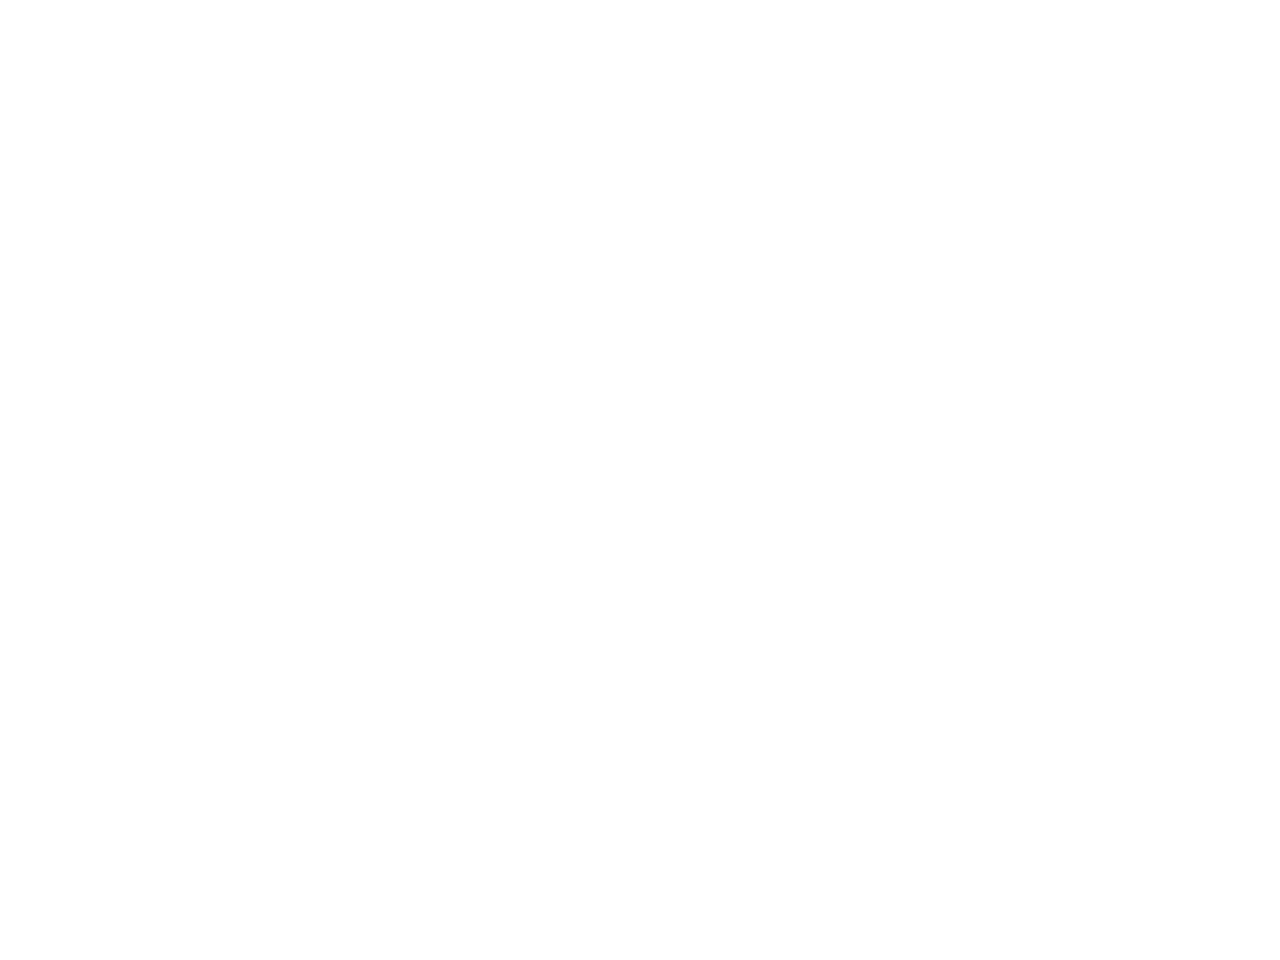

In [14]:
# 2. Boxplot showing ratios for each condition, but only for trials for
# which the approach was from the back

fig, ax = plt.subplots()
allratios = sns.boxplot(x="ratiofront", y="run", #notch=True, 
                        palette=COLORS, data=ratiodf_f_b.query('Approach == "Back"'), ax=ax)
allratios.set_xlim(0,1)
allratios.set_ylabel('Condition')
allratios.set_xlabel('Ratio of gaze on front road')
allratios.set_title('All conditions (Back Approach)')
plt.tight_layout() # needed to show y-label
plt.show()

<IPython.core.display.Javascript object>


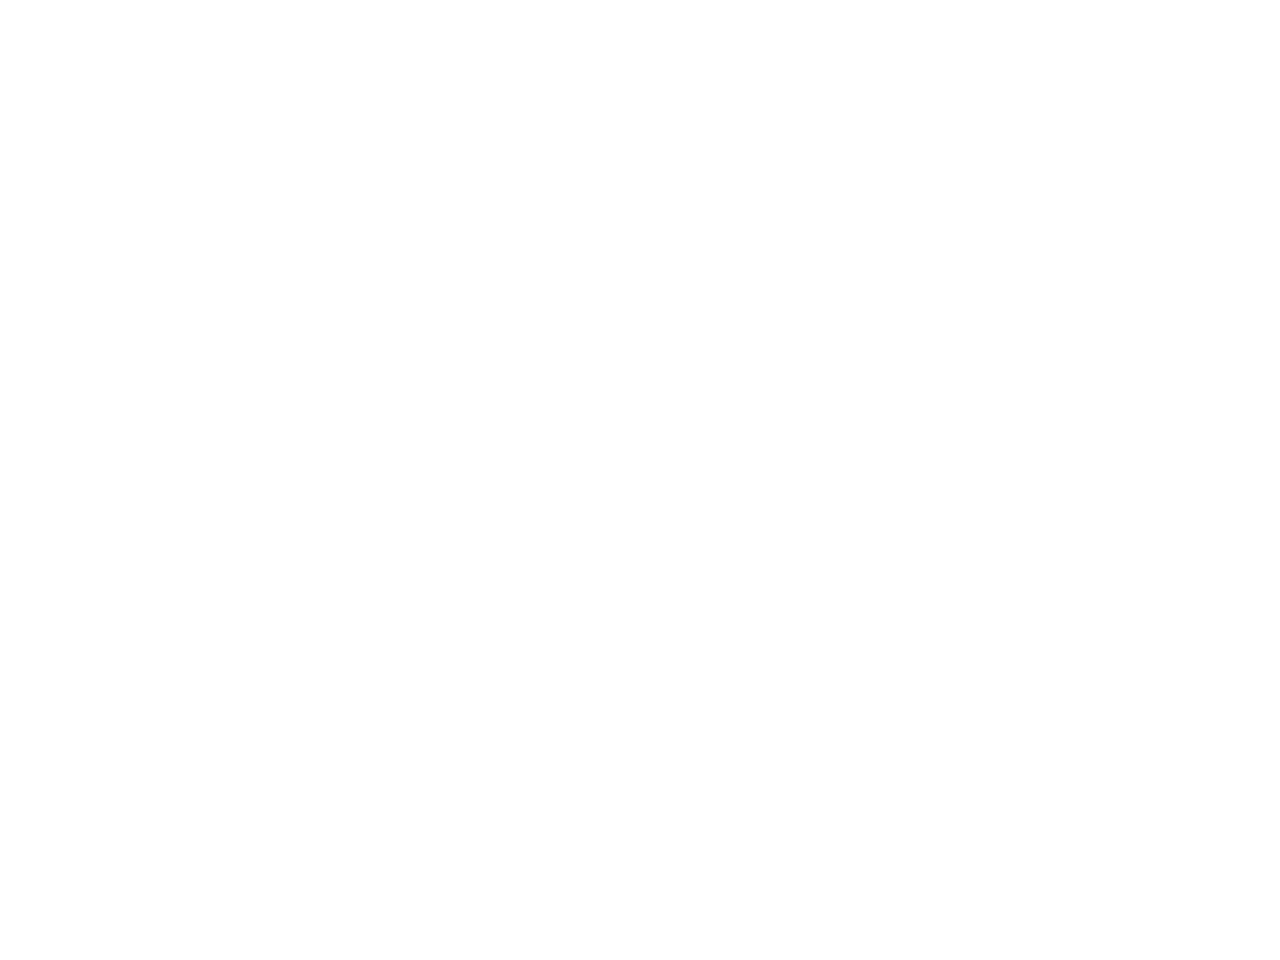

In [15]:
# 3. Boxplot showing ratios for conditions with Human uncertainty, 
# but only for trials for which the approach was from the back

condition = 'Approach == "Back" and (run == "MC-HU" or run == "MUC-HU" or run == "MU-HU (bl)")'

fig, ax = plt.subplots()
allratios = sns.boxplot(x="ratiofront", y="run", #notch=True, 
                        palette=COLORS, 
                        data=ratiodf_f_b.query(condition), ax=ax)

allratios.set_xlim(0,1)
allratios.set_ylabel('Condition')
allratios.set_xlabel('Ratio of gaze on front road')
allratios.set_title('Human uncertain conditions (Back Approach)')
plt.tight_layout() # needed to show y-label
plt.show()

In [16]:
# Do t-test across conditions:

from scipy import stats
from numpy import std, mean, sqrt

def cohen_d(x,y):
# denominator is pooled standard deviation which is generally only appropriate 
# if the population standard deviation is equal for both groups:
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

# comparison: Human uncertain without any communication vs human uncertain with machine uc communication
# human uncertain with machine uc communication and human uncertain with perfect machine

mu_hu = ratiodf_f_b.query('Approach == "Back" and run == "MU-HU (bl)"').ratiofront
muc_hu = ratiodf_f_b.query('Approach == "Back" and run == "MUC-HU"').ratiofront
mc_hu = ratiodf_f_b.query('Approach == "Back" and run == "MC-HU"').ratiofront

print('sample sizes: {},{},{}'.format(len(mu_hu), len(muc_hu), len(mc_hu)))

# using .ttest_ind due to different sample sizes
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
mu_hu_vs_muc_hu = stats.ttest_ind(mu_hu, muc_hu) 
mu_hu_vs_mc_hu = stats.ttest_ind(mu_hu, mc_hu)
mu_hu_vs_muc_hu_d = cohen_d(mu_hu, muc_hu)
mu_hu_vs_mc_hu_d = cohen_d(mu_hu, mc_hu)
                          
print("mu_hu_vs_muc_hu: {}, cohens d: {}".format(mu_hu_vs_muc_hu, mu_hu_vs_muc_hu_d))
print("mu_hu_vs_mc_hu: {}, cohens d: {}".format(mu_hu_vs_mc_hu, mu_hu_vs_mc_hu_d))

# alt: Anova since we have more than two groups
# (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway):

aov = stats.f_oneway(mu_hu, muc_hu, mc_hu)
print(aov)

# post hoc tests
#from scipy.stats.multicomp import pairwise_tukeyhsd
#from scipy.stats.multicomp import MultiComparison
#mc = MultiComparison(ratiodf_f_b.query('Approach == "Back"').run, ratiodf_f_b.query('Approach == "Back"').ratiofront)
#result = mc.tukeyhsd()
#print(result)
#print(mc.groupsunique)

sample sizes: 0,0,77
mu_hu_vs_muc_hu: Ttest_indResult(statistic=nan, pvalue=nan), cohens d: nan
mu_hu_vs_mc_hu: Ttest_indResult(statistic=nan, pvalue=nan), cohens d: nan
F_onewayResult(statistic=nan, pvalue=nan)


/Users/tom/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


<IPython.core.display.Javascript object>


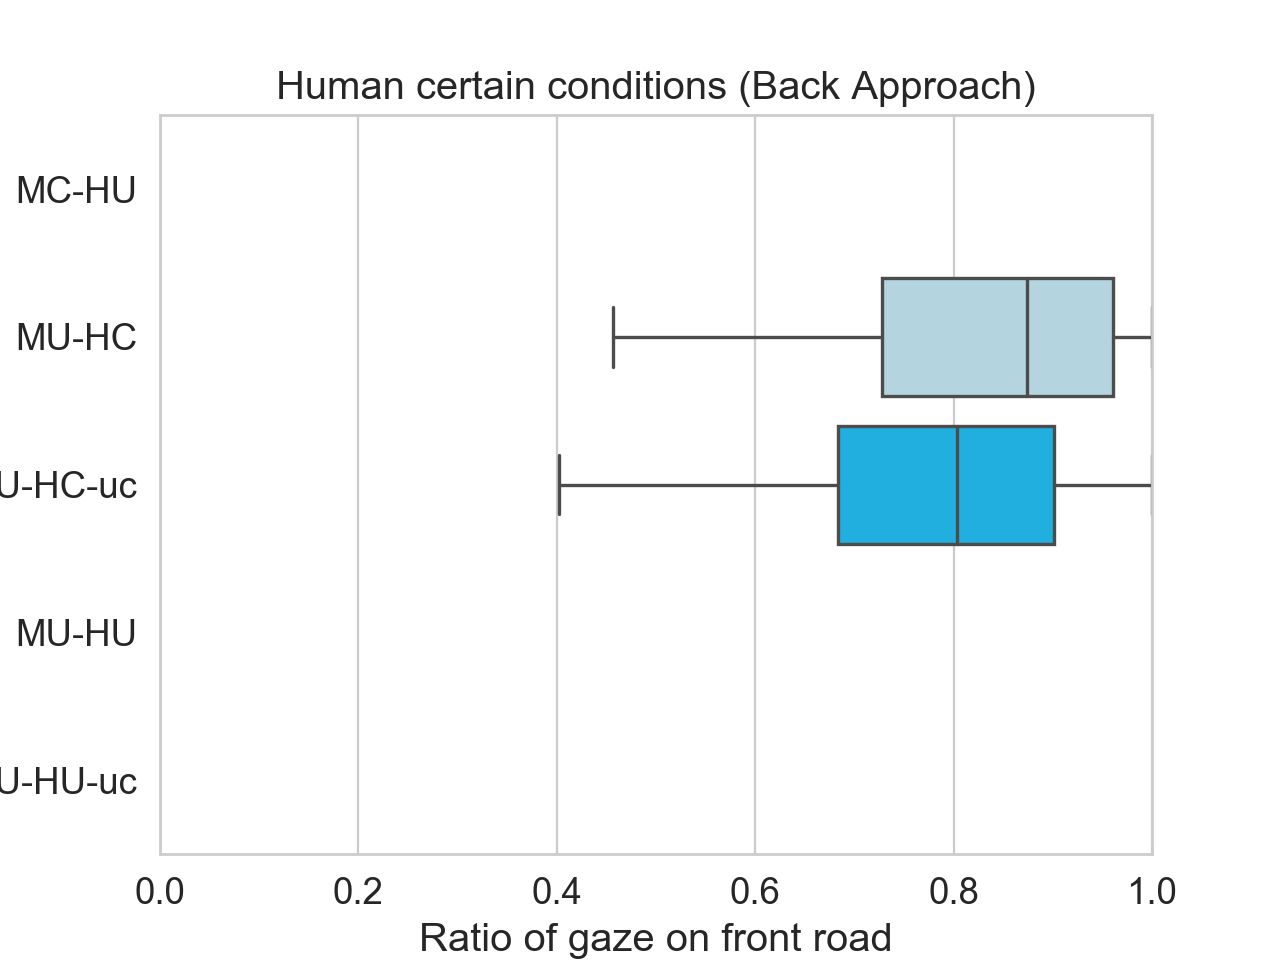

In [32]:
# 4. Boxplot showing ratios for conditions with Human certainty, 
# but only for trials for which the approach was from the back

condition = 'Approach == "Back" and (run == "MU-HC-uc" or run == "MU-HC")'

fig, ax = plt.subplots()
allratios = sns.boxplot(x="ratiofront", y="run", notch=False, 
                        palette=COLORS, 
                        data=ratiodf_f_b.query(condition), ax=ax)

allratios.set_xlim(0,1)
allratios.set_ylabel('Condition')
allratios.set_xlabel('Ratio of gaze on front road')
allratios.set_title('Human certain conditions (Back Approach)')
plt.show()

Plotting all data points:

In [18]:

condition = 'Approach == "Back" and (run == "MU-HU-uc" or run == "MU-HU" or run == "MU-HC-uc" or run == "MU-HC")'

fig, ax = plt.subplots()
allratios = sns.boxplot(x="ratiofront", y="run", notch=False, 
                        palette=COLORS, 
                        data=ratiodf_f_b.query(condition), ax=ax)

allratios.set_xlim(0,1)
allratios.set_ylabel('Condition')
allratios.set_xlabel('Ratio of gaze on front road')
allratios.set_title('Ratio of gaze on front road for encounters with vehicles from the rear')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

Plotting the scores per participant:

In [19]:
selected = ratiodf_f_b.query(condition)

a = selected[selected.run == 'MU-HC']
b = selected[selected.run == 'MU-HC-uc']

c = selected[selected.run=='MU-HU']
d = selected[selected.run=='MU-HU-uc']

In [20]:
dfab = {'participant':[], 'scorea':[], 'scoreb':[]}
for p in a['participant'].unique():
    pmeana = a.loc[a['participant']==p,'ratiofront'].mean()
    pmeanb = b.loc[b['participant']==p,'ratiofront'].mean()
    dfab['participant'].append(p)
    dfab['scorea'].append(pmeana)
    dfab['scoreb'].append(pmeanb)
dfab = pd.DataFrame(dfab)

dfcd = {'participant':[], 'scorec':[], 'scored':[]}
for p in c['participant'].unique():
    pmeanc = c.loc[c['participant']==p,'ratiofront'].mean()
    pmeand = d.loc[d['participant']==p,'ratiofront'].mean()
    dfcd['participant'].append(p)
    dfcd['scorec'].append(pmeanc)
    dfcd['scored'].append(pmeand)
dfcd = pd.DataFrame(dfcd)

In [21]:
dfab

,participant,scorea,scoreb
0,TWOU,0.955911,0.924272
1,MVNT,0.781360,0.952927
2,ZPQX,0.813249,0.814185
3,PVNT,0.815274,0.511555
4,OYWO,0.920972,0.852835
5,PVOU,0.839490,0.780886
6,WVPV,0.680045,0.706660
7,TTVN,0.819404,0.611929
8,QPMS,0.805773,0.761372
9,XSMS,0.832669,0.753415


In [22]:
dfcd

,participant,scorec,scored
0,TWOU,0.985793,0.777544
1,ZPQX,0.985945,0.875412
2,PVNT,0.920191,0.668418
3,OYWO,1.000000,0.872791
4,PVOU,0.981380,0.891308
5,WVPV,0.868716,0.770538
6,TTVN,0.952358,0.948353
7,QPMS,0.870201,0.812621
8,UVUM,0.959493,0.932541
9,XSMS,0.947055,0.942344


In [23]:
A = dfab[['participant', 'scorea']]
A = pd.concat([A, pd.DataFrame({'run':['MU-HC']*len(dfab)})],axis = 1)


B = dfab[['participant', 'scoreb']]
B = pd.concat([B, pd.DataFrame({'run':['MU-HC-uc']*len(dfab)})],axis = 1)

C = dfcd[['participant', 'scorec']]
C = pd.concat([C, pd.DataFrame({'run':['MU-HU']*len(dfcd)})],axis = 1)

D = dfcd[['participant', 'scored']]
D = pd.concat([D, pd.DataFrame({'run':['MU-HU-uc']*len(dfcd)})],axis = 1)

A.columns = ['participant', 'score', 'run']
B.columns = ['participant', 'score', 'run']
C.columns = ['participant', 'score', 'run']
D.columns = ['participant', 'score', 'run']

In [24]:
merged  =pd.concat([A,B,C,D])

In [25]:
from scipy import stats
wil_ab = stats.wilcoxon(dfab['scorea'], dfab['scoreb'])
wil_cd = stats.wilcoxon(dfcd['scorec'], dfcd['scored'])
# stats.ttest_rel(df['scorea'], df['scoreb'])

In [26]:
wil_ab

WilcoxonResult(statistic=24.0, pvalue=0.13295729296233563)

In [27]:
wil_cd

WilcoxonResult(statistic=0.0, pvalue=0.0014737808438751421)

In [28]:
.1329/2

0.06645

In [29]:
.00147/3

0.00049

<IPython.core.display.Javascript object>


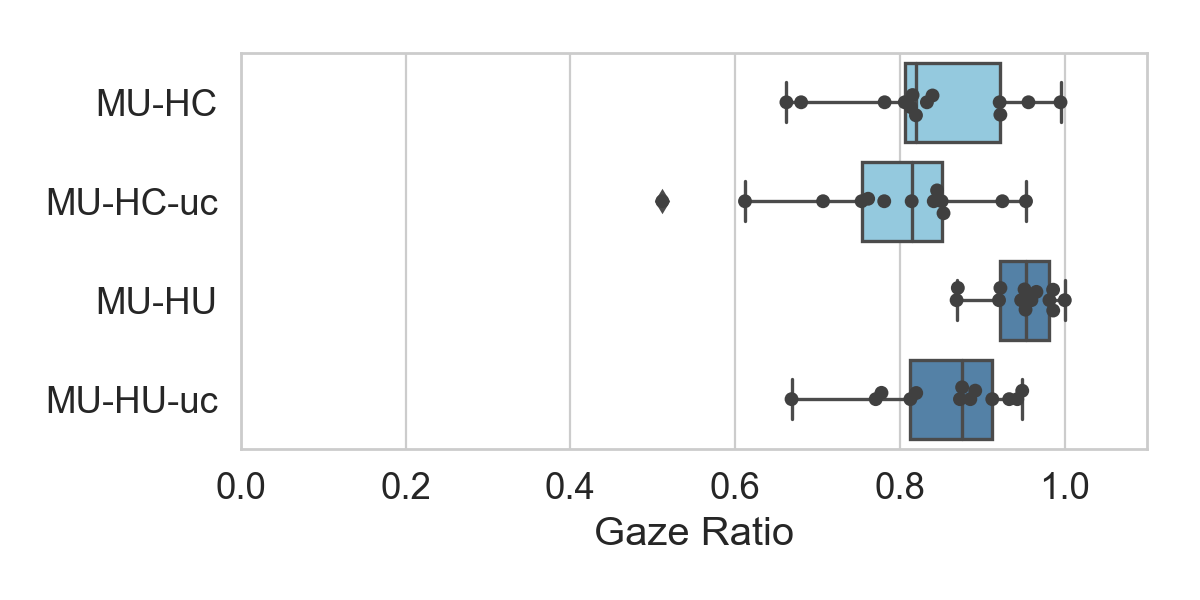

In [42]:
fig, ax = plt.subplots(figsize = (6,3))
sns.set_context('paper', font_scale=1.5)

clrs = ['skyblue', 'skyblue', 'steelblue', 'steelblue']

sns.set_style('whitegrid')
sns.boxplot(y='run', x='score', data=merged, ax=ax, palette = clrs) #color = 'skyblue')

sns.swarmplot(y='run', x='score', data=merged, color=".25", ax = ax)
ax.set_xlim(0,1.1)

plt.ylabel('')
plt.xlabel('Gaze Ratio')
plt.tight_layout()
plt.savefig('gazeratio.eps')


In [31]:
x    nouctun_scores = pd.concat([nouctun_scores, pd.DataFrame({'run': ['nouctun']*len(nouctun_scores)})], axis = 1)
    uctun_scores = pd.concat([uctun_scores, pd.DataFrame({'run': ['uctun']*len(uctun_scores)})], axis = 1)
    noucfog_scores = pd.concat([noucfog_scores, pd.DataFrame({'run': ['foggyroad']*len(noucfog_scores)})], axis = 1)

    merged = pd.concat([nouctun_scores, uctun_scores, noucfog_scores])

    # Usual boxplot
    
    fig, ax = plt.subplots(figsize = (6,2))
    sns.set_context('paper', font_scale=1.5)

#     plt.tight_layout()
    sns.set_style('whitegrid')
    sns.boxplot(y='run', x='score', data=merged, ax=ax, color = 'skyblue')

    # Add jitter with the swarmplot function.
    sns.swarmplot(y='run', x='score', data=merged, color="grey", ax = ax)
    plt.yticks([0,1,2],['MU-HU','MU-HU-uc','MC-HU'])
    ax.set_title(title)
    plt.xlabel('MTTC [s]')
    plt.tight_layout()

SyntaxError: invalid syntax (<ipython-input-31-9d4da8f75c60>, line 1)